This is my first code on trying some basics on nltk library. 

The data is taken from kaggle : https://www.kaggle.com/datasnaek/youtube-new#GBvideos.csv
It has information for each video about when it was in the trending list, tittle of the video, channel that video belongs to,likes , dislikes etc. 
This was the dataset used for one of my projects in summer semester, to see various trends on youtube.
We further discussed about how using nltk, can we build a system that can provide what tags, tittle belonging to particular category can be useful and trend the most 

Business Application would be that such a system would help the companies and youtubers to make sure they are applying correct tags and adding necessary elements to their tittle which can help them in making their video being watched by maximum users 

In [2]:
## Starting by importing various libraries
import numpy as np
import pandas as pd
import json
import nltk as nt

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as wnl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We downloaded the nltk library stored in python and now be importing WordNet, which is a NLTK corpus reader, for our use. 

NLTK is that Natuaral Language Toolkit developed by Python which consists of various corpus readers. These collections are generally developed by collecting words, their meanings, parts of speech and other properties. This provides NLTK a good sense of the context in which the word is being used and where it is applied. 

Wordnet is one of the corpus readers in NLTK : https://www.nltk.org/howto/wordnet.html

It can be used for various purposes like getting meanings of multilingual texts, producing similarity scores between two words and other regression and classification techniques used in text analytics 

We will be mainly using it for identifying the "Parts of Speech" of the word used. It is necessary because of the fact that one word can be used as different POS (ex. verb and adjective) depending upon the context in which the word in applied upon. WordNet captures the correct POS applied and gives us the desired results 

In [3]:
nt.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raisi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Glimpse of the data 


Following is the dataset used. For this purpose, we are only restricting ourselves to the US region 

In [23]:
#gb_eda_file = pd.read_csv('C:/Users/raisi/Downloads/Summer 2019/Data Analytics Programming/Project/dataset/USvideos.csv')


#Since category file is a json file, reading it and then adding it back to the main csv on category_id
id_to_category = {}
with open('C:/Users/raisi/Downloads/Summer 2019/Data Analytics Programming/Project/US_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        id_to_category[category['id']] = category['snippet']['title']
        string_dict = dict([(int(k), str(v)) for k, v in id_to_category.items()])
    

#string_dict
gb_eda_file.insert(4, 'category', gb_eda_file['category_id'].map(string_dict))




print("following are the top 10 rows of the data")
gb_eda_file.head()



following are the top 10 rows of the data


,video_id,trending_date,title,channel_title,category,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,Entertainment,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,Entertainment,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


following are the number columns and number of rows

(40949, 17)

 following are the number of videos in each category



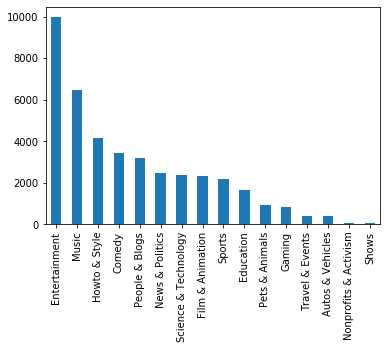

In [39]:

print("following are the number columns and number of rows\n")
print(gb_eda_file.shape)

print("\n following are the number of videos in each category\n")
gb_eda_file['category'].value_counts().plot(kind = 'bar')

## POS TAGGING SYSTEM - RECOMMENDATION FUNCTION

In [58]:
## Function for POS Tagging 

##Checking the stopwords list and adding some more words to it based on some context 
stop = stopwords.words('english')
#type(stop)
stopadd = ['http','https','www','com','nhttp','nhttps']
#stop.append('http','https','www','com')
for k in stopadd:
    stop.append(k)

## Defining the function to filter out the words based on the stop list above 
def wrdfilter(t):    
    tempt = list()
    i = 0    
    for i in range(len(t)):        
        if len(t[i])>1:
            if t[i] not in stop:
                tempt.append(t[i])
    
    return(tempt)

## Adding space to format sentence output
def lstosentence(t):
    p = ""
    i = 0
    for i in range(len(t)):         
        p = p + " " + (t[i])
    return(p)

def vrblistreturn(ne):
    d = list()
    i = 0
    ##Removing some Parts of Speech from the list 
    for i in range(len(ne)):           
        if ne[i][1] not in ["NN","IN","DT","NNP","CD","CC","PRP","TO"]:       
            d.append(ne[i][0])    
    return(d)


def postaggingreturn(d):
    outlst = list()    
    j = 0
    for j in range(len(d)):
        lammitlist = list()       
        ## Taking the description column
        desc = eda_file.loc[j,'tags']        
        if pd.isna(desc) == False:
            ## Finding all the words in description column and making a list out of it 
            desc_clean = re.findall('\w+',desc)
            
            ## Lammitizing the words
            for wr in desc_clean:
                
                ftljoinlammitize = wnl().lemmatize(wr).lower()
                lammitlist.append(ftljoinlammitize)
            
            desc_clean = lammitlist
            
            ## Filtering for the words
            fltt_clean = wrdfilter(desc_clean)
            ## Joining it back to a single sentence for pos_tagging and getting back only the verbs 
            fltjoin_clean = lstosentence(fltt_clean)
            ## Doing POS tagging
            fltjointok = nt.word_tokenize(fltjoin_clean)
            fltjoinpos = nt.pos_tag(fltjointok)
            ## Appending to the list of words
            wrdlist = vrblistreturn(fltjoinpos)
            ## Appending to the uber list
            for ap in wrdlist:
                outlst.append(ap)
    return(outlst)


## Enter the tag or category you want your content to filter for 


Because of the time constraints, I will not be building an interactive API. However, it is easy to make as the codes below are defined in modular format. 
For learning purposes, we can run the blocks one by one to see the properties on NLTK on this dataset 


First, the users inputs the category you think your video belongs to or a tag you think is relevant to your video and then the program is designed to give you realted words or texts associated with such tags or cateogries that were there in trending videos in past history. The idea is that by incorporating similar words in your project, the chances of its video getting viral will increase. 

For example, Suppose we are planning to open a new channel which will make videos regarding "make up". Thus, filtering that word going forward

In [74]:
wordfilter = ['makeup']

## TAG FILTERING BLOCK

In [52]:
## Loading the file for filtering 
gb_tag_file = pd.read_csv('C:/Users/raisi/Downloads/Summer 2019/Data Analytics Programming/Project/dataset/USvideos.csv')

## Changing the date to correct date-time formats to use it further 
gb_tag_file['publish_time'] = pd.to_datetime(gb_tag_file['publish_time'])
gb_tag_file['publish_date'] = pd.to_datetime(gb_tag_file['publish_time'], format = '%Y/%m/%d').dt.date
gb_tag_file['publish_hour'] = pd.to_datetime(gb_tag_file['publish_time'], format = '%Y/%m/%d').dt.hour
gb_tag_file['trending_date'] = pd.to_datetime(gb_tag_file['trending_date'], format = '%y.%d.%m').dt.date
gb_tag_file['publish_to_trend'] = (gb_tag_file['trending_date'] - gb_tag_file['publish_date']).dt.days


## Since the tags are seperated by "|", splliting them to get a list of different tags 
def strings_split(tagsp):
    
    tags_split = tagsp.split("|")
    return(tags_split)
## Calculating the length of the list made from the function above 
def strings_length(tagsl):
    tags_len = len(tagsl)
    return(tags_len)


## Splitting the tags from the "tags" column
gb_tag_file['tag_list'] = gb_tag_file['tags'].map(strings_split)
## Calculating the length of the list made above 
gb_tag_file['tag_list_length'] = gb_tag_file['tag_list'].map(strings_length)



def taglistredone(s):
    test2 = re.findall('\w+',s)
    for i in range(len(test2)):
        test2[i] = test2[i].lower()    
    return(test2)

gb_tag_file['tag_list_mod'] = gb_tag_file['tags'].map(taglistredone)

def tagfilter(s):
    d = wordfilter
    check = 0
    for kj in d:
        #print(kj)
        if kj in s:            
            check = check + 1
        #else:
            #return('no')
    if check > 0:
        return('yes')
    else:
        return('no')

gb_tag_file['fltr'] = gb_tag_file['tag_list_mod'].map(tagfilter)

gb_tag_file = gb_tag_file[gb_tag_file['fltr'] == 'yes']
gb_tag_file.reset_index(inplace = True)
#eda_file['tags'] = eda_file['title']
gb_tag_file = gb_tag_file[['video_id','title','tags']].drop_duplicates().reset_index()
gb_tag_file[:5]

,index,video_id,title,tags
0,0,BWPrk9PUwQE,iPhone X vs Makeup Transformation (Face ID TEST),"iphone x|""iphonex makeup""|""iphonex test""|""new ..."
1,1,8mhTWqWlQzU,Wearing Online Dollar Store Makeup For A Week,wearing online dollar store makeup for a week|...
2,2,MyEqfBkzESU,EXTREME GOLDEN TAN TRANSFORMATION,"Extreme Tan|""Tanning""|""Tanning Bed""|""How to ge..."
3,3,EYkEshCOhEU,The Ultimate Red Lip Look | Nicole Guerriero,"nicole guerriero|""arriba liqud lipstick""|""colo..."
4,4,RQDphL2MVlM,Everything I Wore This Week! Outfit Diary 1,"Dina|""Tokio""|""Dinatokio""|""Torkia""|""Hijab""|""Hij..."


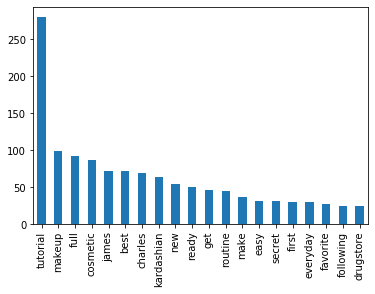

In [59]:

##Adding the output in the POS recommendation system. Making two seperate copies, one for manupulatioin and another to be fed as data in the POS function
eda_file = gb_tag_file.copy()
testing = eda_file.copy()
testing.dropna(inplace = True)
testing.reset_index(inplace = True)
check = postaggingreturn(testing)
checks = pd.Series(check)

checks.value_counts(ascending = False)[:20].plot(kind = "bar")
        

As you can see above, the word tutorial came the most number of times when running for tags as makeup in US trending videos of youtube 

## CATEGORY FILTER BLOCK

In [86]:
wordfilter = ['Music']

In [90]:
# Create dictionary of categories
gb_cat_file = pd.read_csv('C:/Users/raisi/Downloads/Summer 2019/Data Analytics Programming/Project/dataset/USvideos.csv')


id_to_category = {}
with open('C:/Users/raisi/Downloads/Summer 2019/Data Analytics Programming/Project/US_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        id_to_category[category['id']] = category['snippet']['title']
        string_dict = dict([(int(k), str(v)) for k, v in id_to_category.items()])
    

#string_dict
gb_cat_file.insert(4, 'category', gb_cat_file['category_id'].map(string_dict))
gb_cat_file.head()

,video_id,trending_date,title,channel_title,category,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,Entertainment,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,Entertainment,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [88]:
#eda_file = pd.read_csv('C:/Users/raisi/Downloads/Summer 2019/Data Analytics Programming/Project/GBvideos.csv')

gb_cat_file['publish_time'] = pd.to_datetime(gb_cat_file['publish_time'])
gb_cat_file['publish_date'] = pd.to_datetime(gb_cat_file['publish_time'], format = '%Y/%m/%d').dt.date
gb_cat_file['publish_hour'] = pd.to_datetime(gb_cat_file['publish_time'], format = '%Y/%m/%d').dt.hour
gb_cat_file['trending_date'] = pd.to_datetime(gb_cat_file['trending_date'], format = '%y.%d.%m').dt.date
gb_cat_file['publish_to_trend'] = (gb_cat_file['trending_date'] - gb_cat_file['publish_date']).dt.days


def strings_split(s):
    d = s.split("|")
    return(d)

def strings_length(s):
    e = len(s)
    return(e)

gb_cat_file['tag_list'] = gb_cat_file['tags'].map(strings_split)
gb_cat_file['tag_list_length'] = gb_cat_file['tag_list'].map(strings_length)

def taglistredone(s):
    test2 = re.findall('\w+',s)
    for i in range(len(test2)):
        test2[i] = test2[i].lower()    
    return(test2)

gb_cat_file['tag_list_mod'] = gb_cat_file['tags'].map(taglistredone)


def catfilter(s):
    
    d = wordfilter
    
    if s in d:
        return('yes')
    else:
        return('no')

gb_cat_file['fltr'] = gb_cat_file['category'].map(catfilter)

gb_cat_file = gb_cat_file[gb_cat_file['fltr'] == 'yes']
gb_cat_file.reset_index(inplace = True)
gb_cat_file['tags'] = gb_cat_file['title']
gb_cat_file = gb_cat_file[['video_id','title','tags']].drop_duplicates().reset_index()
gb_cat_file[:2]

C:\Users\raisi\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,index,video_id,title,tags
0,0,5E4ZBSInqUU,Marshmello - Blocks (Official Music Video),Marshmello - Blocks (Official Music Video)
1,1,n1WpP7iowLc,Eminem - Walk On Water (Audio) ft. Beyoncé,Eminem - Walk On Water (Audio) ft. Beyoncé


C:\Users\raisi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\raisi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 53444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\raisi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\raisi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\raisi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\raisi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48169 missing from c

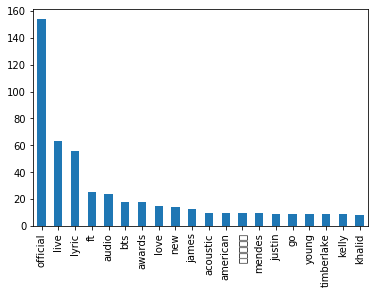

In [89]:

##Adding the output in the POS recommendation system. Making two seperate copies, one for manupulatioin and another to be fed as data in the POS function
eda_file = gb_cat_file.copy()
testing = eda_file.copy()
testing.dropna(inplace = True)
testing.reset_index(inplace = True)
check = postaggingreturn(testing)
checks = pd.Series(check)

checks.value_counts(ascending = False)[:20].plot(kind = "bar")
        